Model parameters thus far:
- Hidden size of 256
- Number of attention heads: 8
- Number of layers: 4
- MLP Ratio: 4
- Dropout: 0.2
- Positional Encoding: Learned

**Objectives:**
- To find the type of activation function that gives the best performance.
- To experiment with batch size
- Find the best learning rate + optimizer combination that gives the best performance

**Evaluation metrics:**
- Validation Loss (averaged cross-entropy loss over all tokens) for performance
- Total training time

### **Importing**

Import data, libraries and functions

In [ ]:
# Import all modules and functions
import scripts.functions as functions
from functions import *

In [ ]:
# Import train and test sets
train_text_int = np.load("train_text_int.npy")
test_text_int = np.load("test_text_int.npy")

# For model tuning, separate train_text_int into training and validation sets
print(len(train_text_int))

# 1/9 of the training set will be used for validation
val_text_int = train_text_int[-10_000_000:]
training_text_int = train_text_int[:80_000_000]
print(len(val_text_int))
print(len(training_text_int))

90000000
10000000
80000000


In [ ]:
# Import model
import models.transformer_III as intermediate_transformer

In [ ]:
# a single gradient update
def train_step(params, opt_state, x, y, tx):
    """
    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B_seq, B_tok) int array input tokens.
      y: (B_seq, B_tok) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients of loss w.r.t params (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: update params and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

In [ ]:
import yaml

with open("./conf/config3.yml", "r") as f:
    cfg = yaml.safe_load(f)
    print(cfg)

# model parameters
vocab_size = cfg['vocab_size']
d_model = cfg['d_model']
n_layers = cfg['n_layers']
n_heads = cfg['n_heads']
max_len = cfg['max_len']
mlp_ratio = cfg['mlp_ratio']
dropout = cfg['dropout']

{'vocab_size': 27, 'd_model': 256, 'n_layers': 4, 'n_heads': 8, 'max_len': 128, 'mlp_ratio': 4, 'dropout': 0.2, 'activation': ['GeLU', 'SiLU', 'ReLU'], 'g_activation': ['SwiGLU', 'GeGLU', 'GeLU'], 'batch_size': [32, 64, 128, 256], 'learning_rate': [0.01, 0.005, 0.001, 0.0005, 0.0001]}


## **Different activation functions**

The current activation function used in the MLP sub-layer is the GeLU, or the Gassian Error Linear Unit. Bias is added inside the dense layers of the model to ensure a more accurate fitting of data.

GeLU is the standard function in many transformer models. This section dives into other activation functions, such as SwiGLU and GeGLU (a family of GLU functions that introduce gating to the FF MLP layer) and SiLU/Swish, a recent activation function proposed between 2017 and 2018.



In [ ]:
# Set the fixed learning rate to be 0.001
lr = 0.001

### **Activation Phase 1**

For this section, experiment with non-gated activation functions, ReLU and the more modern SiLU, and compare against the control setup using GeLU.

- nonlinear(x @ w + b)

In [ ]:
# Initialize the model architecture and params
def create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, activation, mlp_ratio, dropout):
    model = intermediate_transformer.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len, activation, mlp_ratio, dropout)

    # Create dummy input for initialization of batch size 1, seq length min(16, max_len)
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # Initialize the parameters and extracts the PyTree of params
    params = model.init({"params": key}, dummy)["params"]
    return model, params

In [ ]:
activation = cfg['activation']
print(activation)

['GeLU', 'SiLU', 'ReLU']


In [ ]:
# Keep track of all results
val_loss_all = []
training_time_all = []

for act in activation:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, act, mlp_ratio, dropout
                                       )
    print(f"Transformer model initialized with activation function {act} in MLP sublayer.")

    tx = optax.adam(learning_rate=lr)
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    training_time_all.append(time_val_history)

Transformer model initialized with activation function GeLU in MLP sublayer.
Transformer model initialized with activation function SiLU in MLP sublayer.
Transformer model initialized with activation function ReLU in MLP sublayer.


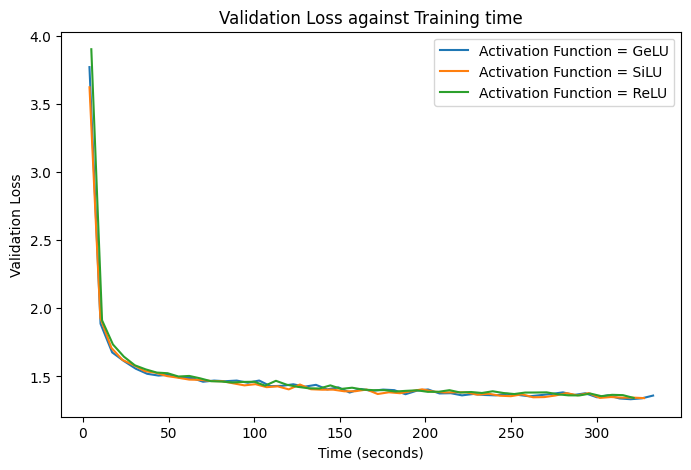

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(activation)):
    plt.plot(training_time_all[i], val_loss_all[i], label = f"Activation Function = {activation[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss against Training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Compare the full training times and final validation losses of all models
for i in range(0, len(activation)):
    string = f"""
    Model with {activation[i]} as the activation function inside MLP layer:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {training_time_all[i][-1]}
    """
    print(string)


    Model with GeLU as the activation function inside MLP layer:
    Final validation loss: 1.3596882820129395
    Total Training Time: 332.9971036911011
    

    Model with SiLU as the activation function inside MLP layer:
    Final validation loss: 1.340915322303772
    Total Training Time: 327.7253751754761
    

    Model with ReLU as the activation function inside MLP layer:
    Final validation loss: 1.3421976566314697
    Total Training Time: 321.6420772075653
    


In [ ]:
# Get the minimum validation loss for each experiment
for i in range(0, len(activation)):
    string = f"""
    Model with {activation[i]} as the activation function inside MLP layer:
    Minimum validation loss: {min(val_loss_all[i])} attained at {training_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    Model with GeLU as the activation function inside MLP layer:
    Minimum validation loss: 1.3328161239624023 attained at 319.90676975250244 seconds
    

    Model with SiLU as the activation function inside MLP layer:
    Minimum validation loss: 1.340915322303772 attained at 327.7253751754761 seconds
    

    Model with ReLU as the activation function inside MLP layer:
    Minimum validation loss: 1.3421976566314697 attained at 321.6420772075653 seconds
    


### **Activation Phase 2**

For this section, experiment with two gated linear units for GeLU and SiLU, GeGLU and SwiGLU respectively, and compare with the control optimal setup using GeLU.

- (x @ W1 + b1) * nonlinear(x @ W2 + b2)


In [ ]:
gated_activation = cfg['g_activation']
print(gated_activation)

['SwiGLU', 'GeGLU', 'GeLU']


In [ ]:
# Keep track of all results
val_loss_all = []
training_time_all = []

for act in gated_activation:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, act, mlp_ratio, dropout
                                       )
    print(f"Transformer model initialized with activation function {act} in MLP sublayer.")

    tx = optax.adam(learning_rate=lr)
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    training_time_all.append(time_val_history)

Transformer model initialized with activation function SwiGLU in MLP sublayer.
Transformer model initialized with activation function GeGLU in MLP sublayer.
Transformer model initialized with activation function GeLU in MLP sublayer.


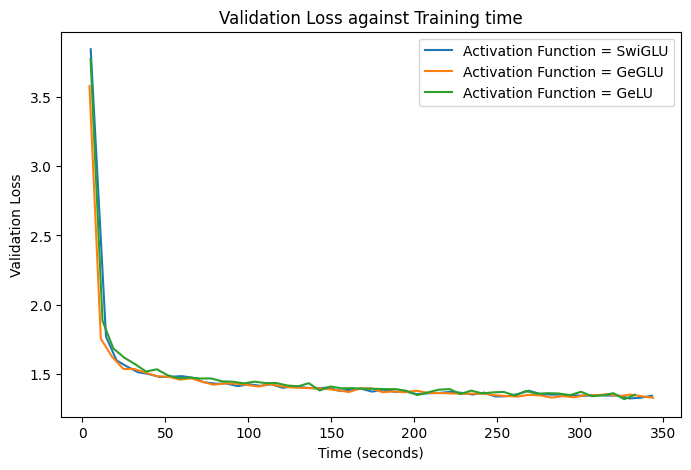

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(gated_activation)):
    plt.plot(training_time_all[i], val_loss_all[i], label = f"Activation Function = {gated_activation[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss against Training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Compare the full training times and final validation losses of all models
for i in range(0, len(gated_activation)):
    string = f"""
    Model with {gated_activation[i]} as the activation function inside MLP layer:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {training_time_all[i][-1]}
    """
    print(string)


    Model with SwiGLU as the activation function inside MLP layer:
    Final validation loss: 1.3459233045578003
    Total Training Time: 343.4663772583008
    

    Model with GeGLU as the activation function inside MLP layer:
    Final validation loss: 1.3310291767120361
    Total Training Time: 344.17027163505554
    

    Model with GeLU as the activation function inside MLP layer:
    Final validation loss: 1.3529770374298096
    Total Training Time: 333.2810471057892
    


In [ ]:
# Get the minimum validation loss and respective timestamp for each experiment
for i in range(0, len(gated_activation)):
    string = f"""
    Model with {gated_activation[i]} as the activation function inside MLP layer:
    Minimum validation loss: {min(val_loss_all[i])} attained at {training_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    Model with SwiGLU as the activation function inside MLP layer:
    Minimum validation loss: 1.3262832164764404 attained at 329.9725275039673 seconds
    

    Model with GeGLU as the activation function inside MLP layer:
    Minimum validation loss: 1.3310291767120361 attained at 344.17027163505554 seconds
    

    Model with GeLU as the activation function inside MLP layer:
    Minimum validation loss: 1.3208296298980713 attained at 326.7837917804718 seconds
    


## **Evaluation**
**Phase 1:**
- From the plot, all models have a similar rate of convergence.
- The final results show that the control model using GeLU exhibits the fastest rate of convergence to a minimum validation loss, of which it is also smaller compared to the other two models.
- By observing the results, there seems to be no significant improvement in model performance or training time when switching to SiLU or ReLU. Therefore, GeLU is still the best activation function moving forward.

**Phase 2:**
- From the plot, it appears that models fitted with the gated activation functions have a similar rate of convergence as the control activation function, GeLU. The gated variant of GeLU, however, does **initially appear** to have the fastest rate of convergence.
- Final results show that that there is also no improvement in validation loss or training time for both gated LU variants compared to the default function GeLU

**Decision:**

The decision is to use GeLU as the optimal activation function for future experiments.


In [ ]:
activation = 'GeLU'

# **Hyperparameter Tuning I**
In the following section, the hyperparameters tuned are batch size, or the number of sequences in a batch (`B_seq`), the `learning_rate` and the type of optimizer.

Tuning will be split into two phases separately:
- First phase is the experimentation with different batch sizes.
- Second phase is experimentation with different optimizers and learning rates.


**Questions to be answered:**
- Does increasing/decreasing batch size or learning rate affect the convergence rate to a minimal loss? Does it change the minimum validation loss?
- Does optimal learning rate vary across the different optimizers? If so, what is the optimal learning rate for each optimizer and how does a change in learing rate affect the convergence rate of loss?
- What are the values that give the optimal performance for the model when they are adjusted as part of training procedure?

The current model is trained on a batch size of 64 and initialized with the Adam optimizer with a learning rate of 0.001.


## **Batch size experimentation**

In [ ]:
# Experiment with different batch sizes
batch_size = cfg['batch_size']
print(batch_size)

[32, 64, 128, 256]


In [ ]:
# Keep track of all results
val_loss_all = []
training_time_all = []

for b in batch_size:

    model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, activation, mlp_ratio, dropout)
    print(f"Transformer model trained on a batch size of {b}.")

    tx = optax.adam(learning_rate=lr)
    # Initialize optimizer state for current params
    opt_state = tx.init(params)

    niter = 20_000                    # reduced no of iterations for each experiment
    B_seq, B_tok = b, 32

    time_start = time.time

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    training_time_all.append(time_val_history)


Transformer model trained on a batch size of 32.
Transformer model trained on a batch size of 64.
Transformer model trained on a batch size of 128.
Transformer model trained on a batch size of 256.


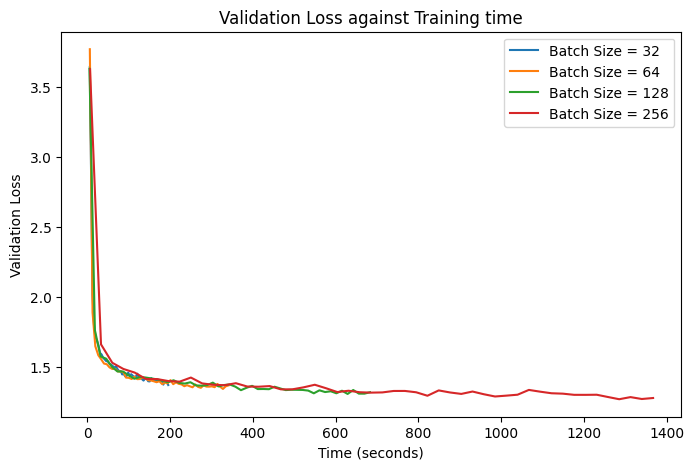

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(batch_size)):
    plt.plot(training_time_all[i], val_loss_all[i], label = f"Batch Size = {batch_size[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss against Training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Compare the full training times and final validation losses of all models
for i in range(0, len(batch_size)):
    string = f"""
    Model trained on a batch size of {batch_size[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {training_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {training_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    Model trained on a batch size of 32:
    Final validation loss: 1.3690474033355713
    Total Training Time: 195.2912905216217
    Minimum validation loss: 1.3690474033355713 attained at 195.2912905216217 seconds
    

    Model trained on a batch size of 64:
    Final validation loss: 1.3662865161895752
    Total Training Time: 340.97793650627136
    Minimum validation loss: 1.341071605682373 attained at 327.60725450515747 seconds
    

    Model trained on a batch size of 128:
    Final validation loss: 1.317533016204834
    Total Training Time: 683.2653648853302
    Minimum validation loss: 1.3054111003875732 attained at 628.9790368080139 seconds
    

    Model trained on a batch size of 256:
    Final validation loss: 1.2762386798858643
    Total Training Time: 1367.5211074352264
    Minimum validation loss: 1.2675437927246094 attained at 1285.5996882915497 seconds
    


### **Evaluation**

From the results, as batch size doubles, training time increases proportionately but the minimum validation loss decreases by quite a fair bit.

For future experiments, a batch size of 64 will be used for tuning and optimization. However, a larger batch size can be considered for training the final model.



## **Optimizer + learning rate**

**Objective:** To find the best optimizer + learning rate combination

In this section, the tuning is carried out as follows:
- Tune the model parameters using the Adam optimizer with different learning rates to find the optimal learning rate for the Adam optimizer.

Do the same for the other optimizers, AdamW and Lion (find their optimal learning rates). Answer what is the best performing optimizer and learning rate pair.

### **Adam optimizer**

In [ ]:
lr = cfg['learning_rate']
print(lr)

[0.01, 0.005, 0.001, 0.0005, 0.0001]


In [ ]:
# Keep track of all results
val_loss_all = []
training_time_all = []

for learning in lr:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    tx = optax.adam(learning_rate=learning)
    print(f"Initialized Adam optimizer with learning rate of {learning}")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    training_time_all.append(time_val_history)

Initialized Adam optimizer with learning rate of 0.01
Initialized Adam optimizer with learning rate of 0.005
Initialized Adam optimizer with learning rate of 0.001
Initialized Adam optimizer with learning rate of 0.0005
Initialized Adam optimizer with learning rate of 0.0001


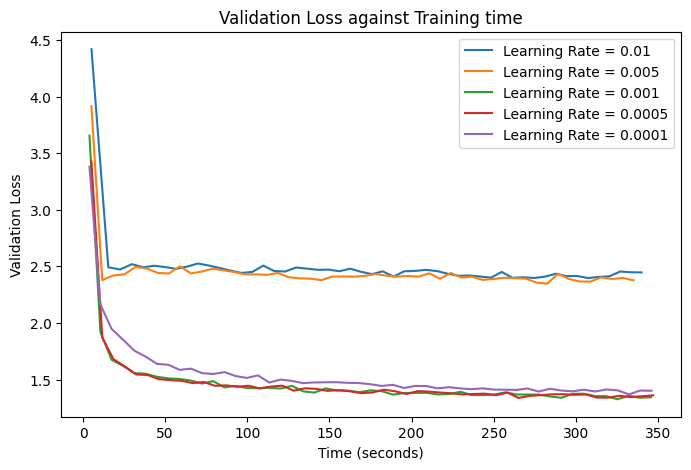

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(lr)):
    plt.plot(training_time_all[i], val_loss_all[i], label = f"Learning Rate = {lr[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss against Training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Compare the results
for i in range(0, len(lr)):
    string = f"""
    Adam Optimizer initialized with a learning rate of {lr[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {training_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {training_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    Adam Optimizer initialized with a learning rate of 0.01:
    Final validation loss: 2.4466404914855957
    Total Training Time: 340.02224707603455
    Minimum validation loss: 2.396529197692871 attained at 307.41042709350586 seconds
    

    Adam Optimizer initialized with a learning rate of 0.005:
    Final validation loss: 2.376446485519409
    Total Training Time: 335.1380612850189
    Minimum validation loss: 2.3478426933288574 attained at 282.63941502571106 seconds
    

    Adam Optimizer initialized with a learning rate of 0.001:
    Final validation loss: 1.3431962728500366
    Total Training Time: 345.79256105422974
    Minimum validation loss: 1.3257660865783691 attained at 325.3359808921814 seconds
    

    Adam Optimizer initialized with a learning rate of 0.0005:
    Final validation loss: 1.3599143028259277
    Total Training Time: 347.0491120815277
    Minimum validation loss: 1.3370254039764404 attained at 265.17634987831116 seconds
    

    Adam Optimizer initi

### **Evaluation**
The results confirmed that the optimal learning rate for Adam optimizer is still 0.001. The learning rate of 0.0005 came close, but in terms of a significant or even a slight improvement, there was not any. In fact, the minimum validation loss is slightly higher in the case of `learning_rate` = 0.0005.

### **AdamW optimizer**

A variant of Adam, the difference between AdamW and Adam is the way that each model uses weight decay in the process of updating the parameters.
- Adam adds weight decay to the gradients.
- AdamW applies weight decay to the parameters directly.

A `weight_decay` value of 0.01 is applied for AdamW.

In [ ]:
# Keep track of all results
val_loss_all = []
training_time_all = []

for learning in lr:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    tx = optax.adamw(learning_rate=learning, weight_decay = 0.01)
    print(f"Initialized AdamW optimizer with learning rate of {learning}")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    training_time_all.append(time_val_history)

Initialized AdamW optimizer with learning rate of 0.01
Initialized AdamW optimizer with learning rate of 0.005
Initialized AdamW optimizer with learning rate of 0.001
Initialized AdamW optimizer with learning rate of 0.0005
Initialized AdamW optimizer with learning rate of 0.0001


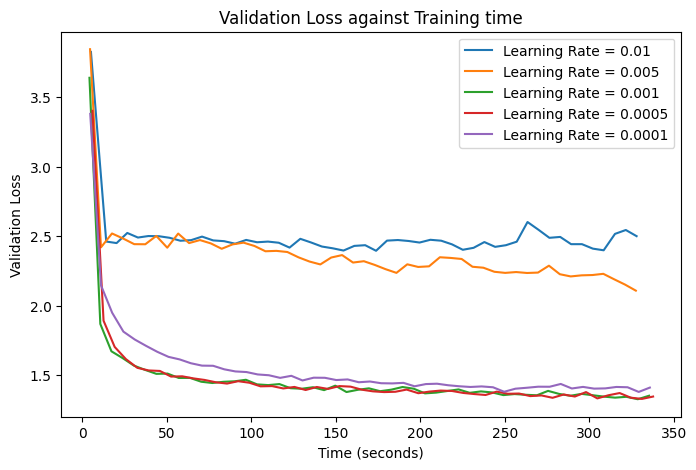

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(lr)):
    plt.plot(training_time_all[i], val_loss_all[i], label = f"Learning Rate = {lr[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss against Training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Compare the results
for i in range(0, len(lr)):
    string = f"""
    AdamW Optimizer with weight decay of 0.01 initialized with a learning rate of {lr[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {training_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {training_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    AdamW Optimizer with weight decay of 0.01 initialized with a learning rate of 0.01:
    Final validation loss: 2.4998111724853516
    Total Training Time: 328.07749485969543
    Minimum validation loss: 2.3946969509124756 attained at 173.89839816093445 seconds
    

    AdamW Optimizer with weight decay of 0.01 initialized with a learning rate of 0.005:
    Final validation loss: 2.1079518795013428
    Total Training Time: 327.62927746772766
    Minimum validation loss: 2.1079518795013428 attained at 327.62927746772766 seconds
    

    AdamW Optimizer with weight decay of 0.01 initialized with a learning rate of 0.001:
    Final validation loss: 1.35223388671875
    Total Training Time: 335.45693588256836
    Minimum validation loss: 1.3271068334579468 attained at 328.78479838371277 seconds
    

    AdamW Optimizer with weight decay of 0.01 initialized with a learning rate of 0.0005:
    Final validation loss: 1.3462848663330078
    Total Training Time: 337.8424723148346
    Min

### **Evaluation**

The results confirm that the optimal learning rates for AdamW with a `weight_decay` value of 0.01 is between 0.001 and 0.0005.

Do both cases outperform the best Adam optimizer and optimal learning rate combination? For reference, the Adam optimizer initialized with a learning rate of 0.001 has a minimum validation loss of 1.3258 after 325.34 seconds.

Contest against the Lion optimizer below.


### **Lion Optimizer**

A new optimizer that instead of using gradient and momentum estimates, it updates weights using the sign of momentum. No weight decay was used here.

In [ ]:
# Keep track of all results
val_loss_all = []
training_time_all = []

for learning in lr:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    tx = optax.lion(learning_rate=learning)
    print(f"Initialized Lion optimizer with learning rate of {learning}")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    training_time_all.append(time_val_history)

Initialized Lion optimizer with learning rate of 0.01
Initialized Lion optimizer with learning rate of 0.005
Initialized Lion optimizer with learning rate of 0.001
Initialized Lion optimizer with learning rate of 0.0005
Initialized Lion optimizer with learning rate of 0.0001


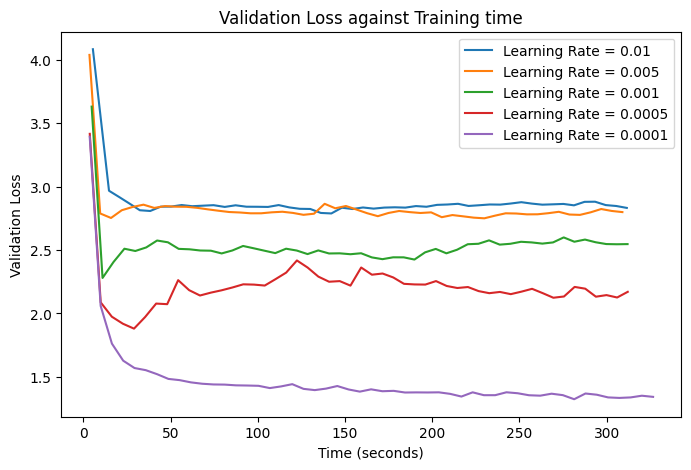

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(lr)):
    plt.plot(training_time_all[i], val_loss_all[i], label = f"Learning Rate = {lr[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss against Training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Compare the results
for i in range(0, len(lr)):
    string = f"""
    Lion Optimizer initialized with a learning rate of {lr[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {training_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {training_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    Lion Optimizer initialized with a learning rate of 0.01:
    Final validation loss: 2.831806182861328
    Total Training Time: 311.5430130958557
    Minimum validation loss: 2.7881555557250977 attained at 142.12178897857666 seconds
    

    Lion Optimizer initialized with a learning rate of 0.005:
    Final validation loss: 2.798769474029541
    Total Training Time: 309.01657342910767
    Minimum validation loss: 2.7498652935028076 attained at 229.86279320716858 seconds
    

    Lion Optimizer initialized with a learning rate of 0.001:
    Final validation loss: 2.546652317047119
    Total Training Time: 311.97915410995483
    Minimum validation loss: 2.2800002098083496 attained at 10.938860893249512 seconds
    

    Lion Optimizer initialized with a learning rate of 0.0005:
    Final validation loss: 2.170664072036743
    Total Training Time: 312.08671522140503
    Minimum validation loss: 1.880637288093567 attained at 28.979542016983032 seconds
    

    Lion Optimizer initia

### **Evaluation**

As seen from the results, the optimal learning rate for the Lion optimizer is 0.0001.

**Decision:** The optimizer and learning rate that will be used for future experiments will be the Lion optimizer and 0.0001 respectively. The Adam optimizer initialized with a learning rate of 0.001 comes very close to this result, but in terms of training time, and final and minimum validation loss, the Lion optimizer beats it in all areas. This goes the same for any AdamW experiments with different learning rates.